# Interpolation

L'[interpolation numérique](https://fr.wikipedia.org/wiki/Interpolation_num%C3%A9rique) consiste à simplifier/approcher une fonction (parfois inconnue globalement) par une autre fonction, ou un ensemble d'autres fonctions. Il s'agit la plupart du temps de faire passer ces fonctions d'interpolation par un nombre fini de points. 

Il existe plusieurs type d'interpolations : 
 - l'[interpolation polynomiale](https://fr.wikipedia.org/wiki/Interpolation_polynomiale) fait passer un polynôme de degrés $n$ à travers un ensemble de $n$ points. L'interpolation linéaire est la forme la plus simple d'interpolation polynomiale.
 - l'interpolation par partie, où l'on cherche un ensemble de fonctions (souvent polynomiales) définies sur des sous-ensembles de la fonction à approcher et ayant des propriétés simplifiant le traitement de la fonction. L'exemple caractéristique de ce type d'interpolation est la [spline](https://fr.wikipedia.org/wiki/Spline), qui consiste à approcher une fonction par un ensemble de polynômes d'ordre $3$.

In [1]:
from fractions import Fraction
from matplotlib import pyplot as plt

## Position du problème

On suppose que l'on a $n+1$ données de la forme $\left(x_{i}, y_{i}\right)$ où tous les points sont différents et pourraient représenter une fonction, c'est-à-dire que $x_{i} \neq x_{j} \Rightarrow y_{i} \neq y_{j}$ et $y_{i} = y_{j} \Leftrightarrow x_{i} = x_{j}$ (les points sont soient identiques, soit clairement séparés). De plus, les points sont ordonnés par les $x_{i}$ : $x_{0} < x_{1} < \cdots < x_{n}$. On cherche une courbe passant par l'ensemble de ces points. Nous avons alors à notre disposition un [théorême puissant, dit de l'interpolation polynmiale](https://en.wikipedia.org/wiki/Polynomial_interpolation#Interpolation_theorem) : par un ensemble de $n+1$ points passera un polynôme de degré $n+1$ unique. Il y a aura donc plusieurs stratégies possibles : 

Soit on cherche une solution globale à notre problème, et on fait passer le seul polynôme de degré $n+1$ par l'ensemble des points de données : c'est l'[interpolation polynomiale](https://fr.wikipedia.org/wiki/Interpolation_polynomiale) (sans précision, ou éventuellement _interpolation polynomiale globale_). Cette méthode peut parfois générer du bruit, les polynômes de haut degré oscillant beaucoup autour des données.

Pour éviter que les on découpe le problème en problèmes plus simples en prenant des sous-ensemble de points contigüs, et en faisant passer des polynômes plus simples par ces sous-ensembles de points. Par exemple si on prend les points deux-à-deux $\left(x_{1}, y_{1}, x_{2}, y_{2}\right)$, puis $\left(x_{2}, y_{2}, x_{3}, y_{3}\right)$, ..., on pourra chercher la droite passant par chacun de ces deux points. On aura alors $n$ droites pour $n+1$ points. On peut faire de même en faisant passer des paraboles (polynômes de degré deux) par des ensemble de trois points, ... D'après le théorême de l'interpolation polynmiale, cela est toujours possible. On aprle alors d'**interpolation polynomiale par morceaux**. Dans ce cas, les fonction obtenues sont continues mais pas forcément leurs dérivées ... 

La dernière méthode consiste à prendre des ensemble _recouvrant_ de points contigüs, et à faire passer des polynômes d'ordre supérieur au nombre de points pris, mais en rajoutant des conditions de continuité pour les points passant par plusieurs courbes. C'est le cas par exemple des [spline](https://fr.wikipedia.org/wiki/Spline), qui consistent à approcher une fonction par un ensemble de polynômes d'ordre $3$ pour trois points successifs, et en imposant que les dérivées premières soient continues.

## Interpolation polynomiale

Dans le cadre de l'interpolation polynomiale, on cherche une seule fonction (un polynôme) passant par l'ensemble des points. On écrit un polynôme général d'ordre $n$ de la forme $p\left(x\right) = a_{n}x^{n} + a_{n-1}x^{n-1} + \cdots + a_{1}x+a_{0}$ et on a donc $n+1$ inconnues $a_{i}$ à trouver. Si l'on substitue l'ensemble des points de données, on aura $n+1$ équations linéaires (en $a_{i}$, pas en $x$) que l'on peut résoudre par la méthode du pivot de Gauss par exemple. 

In [2]:
def lower_elimination(A, b):
    """Apply Gauss elimination to eliminate the lower part of the A matrix."""
    for i in range(len(A)):
        for j in range(i+1, len(A)):
            if A[j][i] != 0:
                line = [A[i][k] - Fraction(A[i][i]*A[j][k], A[j][i])
                        for k in range(len(A))]
                b[j] = b[i] - Fraction(A[i][i]*b[j], A[j][i])
                A[j] = line
    return A, b

def gauss_elimination(A, b):
    """Solve the equation A.x = b. Return x."""
    if len(A) != len(b):
        raise ValueError("A and b must be compatible")
    A, b = lower_elimination(A, b)
    # solve the triangular system exactly, from the last position
    for j in range(len(A)-1, -1, -1):
        numer = b[j] - sum(A[j][i] * b[i] for i in range(j+1, len(A)))
        b[j] = Fraction(numer, A[j][j])
    return b

Créons alors la classe proposant des interpolations polynomiales.

In [3]:
from typing import List, Tuple

class Interpolation():
    """Interpolation class. Pass a list of 2D-tuple in the form (x,y) to the class instanciation. 
    The class will solve the interpolation using the Gauss elimination procedure. 
    Then call Interpolation(x) to know the value of the interpolation polynomial at point x."""
    
    def __init__(self, points: List[Tuple[float, float]]):
        if not all(len(p) == 2 for p in points):
            raise ValueError("only 2D points in the form (x,y) are admissible")
        self.n = len(points)
        # construct the polynomial coefficients
        self.coefficients = self.__solve(points)
        return None
        
    def __solve(self, points):
        A = [[points[j][0]**i for i in range(self.n)] 
             for j in range(self.n)]
        b = [points[j][1] for j in range(self.n)]
        coefficients = gauss_elimination(A, b)
        return coefficients
    
    def __call__(self, x: float):
        """Calculate the value of the interpolation polynomial at point x."""
        return sum(self.coefficients[i]*(x**i) for i in range(self.n))
    
    def __repr__(self):
        return str(self.__class__.__name__) + \
            '(' + ', '.join(str(c) for c in self.coefficients) + ')'

Maintenant, appliquons cette méthode au problème suivant : on donne les points oranges à la classe `Interpolation` ci-dessus, et on produit le polynôme d'interpolation passant par l'ensemble des points.

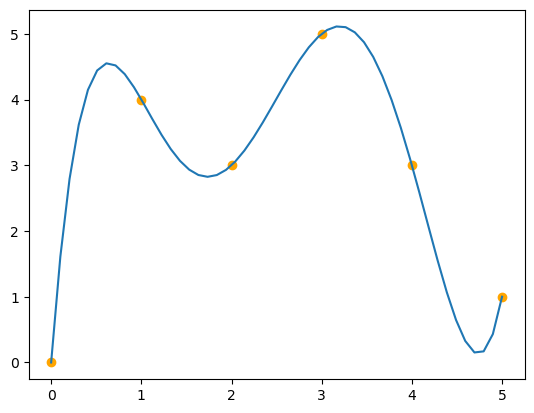

In [4]:
xs = [0, 1, 2, 3, 4, 5]
ys = [0, 4, 3, 5, 3, 1]
points = [(x,y) for x,y in zip(xs, ys)]

i1 = Interpolation(points)

# create intermediary points, for illustration
nb_points = 50
x_interpol = [(min(xs) + (max(xs)-min(xs)))*t/(nb_points-1) 
              for t in range(nb_points)]
y_interpol = [i1(x) for x in x_interpol]

plt.plot(x_interpol, y_interpol)
plt.scatter(xs, ys, color='orange')
plt.show()

Si le polynôme d'interpolation passe bien par l'ensemble des points proposés (c'est le [théorême de l'interpolation polynomiale](https://en.wikipedia.org/wiki/Polynomial_interpolation#Interpolation_theorem)), ce polynôme n'est pas forcément le plus intéressant à dessiner pour dessiner la _meilleure_ courbe passant par l'ensemble des points. Il oscille souvent trop, ou s'écarte trop des points proposés.

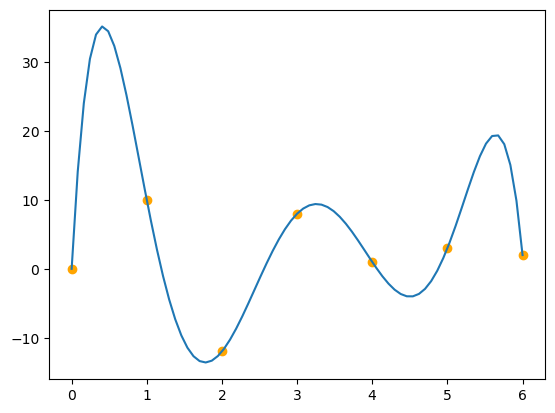

In [5]:
xs = [0, 1, 2, 3, 4, 5, 6]
ys = [0, 10, -12, 8, 1, 3, 2]
points = [(x,y) for x,y in zip(xs, ys)]
i1 = Interpolation(points)

# create intermediary points, for illustration
nb_points = 75
x_interpol = [(min(xs) + (max(xs)-min(xs)))*t/(nb_points-1) 
              for t in range(nb_points)]
y_interpol = [i1(x) for x in x_interpol]

plt.plot(x_interpol, y_interpol)
plt.scatter(xs, ys, color='orange')
plt.show()

### Avantages de l'interpolation polynomiale

Parmis ses nombreuses qualités, citons : 

 - elle est simple à mettre en place, un pivot de Gauss suffit à résoudre le problème
 - elle est mathématiquement robuste : les solutions du problèmes sont connues, des théorêmes d'interpolation s'appliquent, ... 
 - elle permet de compresser ou de filtrer les données : il suffit de quelques points pour recomposer une courbe complète (le problème de la compression est donc le problème inverse de l'interpolation, il s'agit de trouver les points permettant de conserver le plus fidèlement possible l'allure de la courbe générale) 

### Inconvénients de l'interpolation polynomiale

Si cette méthode est très simple et permet de lisser l'ensemble des points de données, elle souffre de quelques inconvénients : 

 - plus le polynôme d'interpolation est de haut degrès, plus il est instable, certe il passe par tous les points, mais il est fort probable qu'il oscille grandement entre les différents points de données, la courbe _de lissage_ n'est alors pas tellement _lisse_ justement ... c'est le [phénomère de Runge](https://en.wikipedia.org/wiki/Runge%27s_phenomenon)
 - il n'y a aucune symmétrie des équations pour un problème donné, ce qui impose de résoudre le système d'équations de façon brutale, ce qui est parfois numériquement instable. 

```{admonition} Symmétrie et interpolation
:class: note
Dans le même esprit, certaines symmétrie du problème permettent de résoudre le lissage des données par de meilleures méthodes. Par exemple, les problèmes périodiques (ou oscillant) sont beaucoup plus facile à étudier dans le cadre de la [transformée de Fourrier](https://en.wikipedia.org/wiki/Fourier_transform).
```

```{admonition} Instabilité polynomiale et courbes de lissage
:class: hint
Pour résoudre les problèmes liés à l'instabilité des interpolations polynomiales, mais surtout pour chercher à rester proche des points de données, les interpolation par morceaux ont été proposées, parmis lesquelles les interpolations linéaires par morceaux faisant passer une droite par deux points et chacun des points apartenant à deux droites (sauf les points extrêmes qui n'appartiennent qu'à une seule droite), et les [splines](https://fr.wikipedia.org/wiki/Spline) pour lesquelles on fait passer des polynômes d'ordre supérieur entre ces points, en fixant des conditions sur les dérivées des splines, les rendant beaucoup plus lisse que les interpolation linéaire par morceaux. Les splines sont particulièrement efficaces lorsqu'il s'agit de modéliser des profils d'objets, et sont donc particulièrement bien adaptées aux problèmes de l'industrie des objets manufacturés ou des jeux vidéos (bien que dans ce dernier cas, on leur préfère souvent les [courbes de Béziers](https://fr.wikipedia.org/wiki/Courbe_de_B%C3%A9zier).
```

## Interpolation linéaire par morceaux

Commençons par l'exemple le plus simple d'interpolation par morceaux : l'interpolation linéaire. Dans ce cas, on cherche à faire passer une droite entre deux points contigüs de l'ensemble des $\left(x_{i}, y_{i}\right)$. Soit alors $\tilde{y}_i\left(x\right) = a x + b$ la droite qui passe par $\left(x_{i}, y_{i}\right)$ et $\left(x_{i+1}, y_{i+1}\right)$. On cherche les inconnues $a$ et $b$. On doit alors résoudre le système de deux équations à deux inconnues

$$\begin{cases}
y_{i} & = a x_{i}+b\\
y_{i+1} & = a x_{i+1}+b
\end{cases}$$

ce qui nous donne

$$\begin{align}
a & =\frac{y_{i+1}-y_{i}}{x_{i+1}-x_{i}} \\
b & =y_{i+1}-a x_{i+1} = y_{i}-a x_{i} = \frac{y_{i}x_{i+1} - y_{i+1}x_{i}}{x_{i+1}-x_{i}}
\end{align}$$

On peut choisir de représenter l'interpolation linéaire à l'aide la classe d'interpolation ci-dessus, ou de faire une interface dédiée, comme ci-dessous

In [9]:
from typing import List, Tuple

class PiecewiseLinearInterpolation():
    """Interpolation class. Pass a list of 2D-tuple in the form (x,y) to the class instanciation. 
    The class will solve the piecewise linear interpolation. 
    Then call PiecewiseLinearInterpolation(x) to know the value of the interpolation polynomial at point x."""
    
    def __init__(self, points: List[Tuple[float, float]]):
        if not all(len(p) == 2 for p in points):
            raise ValueError("only 2D points in the form (x,y) are admissible")
        self.n = len(points)
        # construct the polynomial coefficients
        self.points = points
        self.coefficients = [self.__solve(p1[0], p2[0], p1[1], p2[1])
                             for p1, p2 in zip(points[:-1], points[1:])]
        return None
        
    def __solve(self, x1, x2, y1, y2) -> Tuple[float, float]:
        a = (y2 - y1) / (x2 - x1)
        b = y1 - a * x1
        return a, b
    
    def __call__(self, x: float) -> float:
        """Calculate the value of the interpolation polynomial at point x."""
        if x < self.points[0][0] or x > self.points[-1][0]:
            raise ValueError("x is not inside the known points")
        i = 1
        while self.points[i][0] < x:
            i += 1
        return self.coefficients[i-1][0] * x + self.coefficients[i-1][1]
    
    def __repr__(self):
        return str(self.__class__.__name__) + \
            '(' + str(self.n) + 'pieces)'

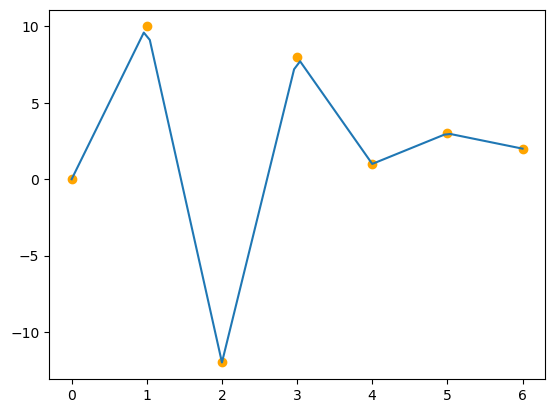

In [10]:
xs = [0, 1, 2, 3, 4, 5, 6]
ys = [0, 10, -12, 8, 1, 3, 2]
points = [(x,y) for x,y in zip(xs, ys)]
i2 = PiecewiseLinearInterpolation(points)

# create intermediary points, for illustration
nb_points = 75
x_interpol = [(min(xs) + (max(xs)-min(xs)))*t/nb_points 
              for t in range(nb_points+1)]
y_interpol = [i2(x) for x in x_interpol]

plt.plot(x_interpol, y_interpol)
plt.scatter(xs, ys, color='orange')
plt.show()

On voit que l'interpolation linéaire par morceaux est très facile à mettre en place. Malheureusement, les discontibuité de la dérivée aux points de données ne sont pas toujours intéressantes. On peut préférer lisser ces courbes d'interpolation, en utilisant par exemple des splines.

## Spline cubique naturelle

L'idée derrière les [splines](https://fr.wikipedia.org/wiki/Spline) est relativement simple : si les polynômes d'interpolation cherchent à résoudre le problème global de passer par l'ensemble des $N$ points à l'aide d'un polynôme d'ordre $N$, les splines découpent le problème en $N$ problèmes plus simples. On cherche ainsi à faire passer un polynôme d'ordre 3 par trois points consécutifs (c'est le problème des splines cubiques décrit ci-dessous), ou un polynôme d'ordre 4 par quatre points consécutifs, ... Ppour retrouver une notion de courbes globales, on va simplement appliquer des condiftions aux bords entre chaque portion de courbes. Ainsi, chacune des splines sera attachée à sa précédente ou suivante selon des règles précises, que l'on va étudier dans la suite. Nous verrons que ces règles permettent d'obtenir une représentation unique de la courbe passant par l'ensemble des points. 

Les [splines cubiques naturelles](https://fr.wikipedia.org/wiki/Spline) permettent de lisser des données naturelles. Entre chaque paire de points de donnée, on va faire passer un polynôme d'ordre trois de la forme $S = a_0 x^3 + a_1 x^2 + a_2 x + a_3$. On aura donc $n$ splines pour notre problème à $n+1$ coordonnées, et $4n$ paramètres à ajuster. On notera la spline $S_i$ qui définira la portion de courbe entre $x_{i-1}$ et $x_{i}$ (attention la spline de gauche est donc notée $S_1$).

Nous allons voir qu'en raison des propriétés de symmétrie du problème, l'ensemble des $4n$ paramètres peuvent se calculer à l'aide de $n$ équations seulement.

Il faut alors faire des choix de conditions aux limites pour chaque polynôme. On les choisit de la façon suivante

 - les splines passent par les points de données  : $S_{i}\left(x_{i-1}\right) = x_{i-1}$ et $S_{i}\left(x_{i}\right) = x_{i}$, ce qui fait $2\left(n-1\right) + 2 = 2n$ conditions ; de plus les splines sont donc continues naturellement sur les données $S_{i}\left(x_{i}\right) = S_{i+1}\left(x_{i}\right) = x_{i}$ bien que cela ne constitue pas une nouvelle condition pour les paramètres 
 - les dérivées premières des splines sont continues aux points qu'elles ont en commun : $S^{\prime}_{i}\left(x_{i}\right) = S^{\prime}_{i+1}\left(x_{i}\right)$, ce qui fait $n-1$ conditions
 - les dérivées secondes des splines sont continues aux points qu'elles ont en commun : $S^{\prime\prime}_{i}\left(x_{i}\right) = S^{\prime\prime}_{i+1}\left(x_{i}\right)$, ce qui fait $n-1$ conditions
 - les dérivées secondes aux points extrêmes sont nulles $S^{\prime\prime}_1\left(x_{0}\right) = 0$ et $S^{\prime\prime}_{n}\left(x_{n}\right) = 0$
 
La dernière condition est un choix arbitraire, et d'autres paramétrisations des splines existent. Si les dérivées secondes des splines s'annulent aux extrémités, on parle de _spline naturelle_.

On a donc bien $4n$ conditions pour les $4n$ paramètres : notre problème est solvable. On peut tout à fait injecter les conditions dans les expression des splines, et obtenir le jeu de $4n$ équations à résoudre. Néanmoins, une astuce mathématique permet de calculer les splines facilement.

```{admonition} Algorithme de calcul des splines et paramétrisation
:class: warning
Il existe de nombreuses représentation des splines en terme de leurs coefficients. En effet, il suffit de résoudre l'ensemble des $4n$ équations ci-dessus pour obtenir l'ensemble des $a_{0}$, $a_{1}$, $a_{2}$ et $a_{3}$ de chaque spline cubique. On peut aussi décider que chaque spline va se mettre sous la forme $S_{i}\left(x\in\left[x_{i-1}, x_{i}\right]\right) = a_{i0} \left(x-x_{i-1}\right)^3 + a_{i1} \left(x-x_{i-1}\right)^2 + a_{i2} \left(x-x_{i-1}\right) + a_{i3}$ et les $4n$ équations associées ne seront plus les mêmes. En résumé, _les équations à résoudre dépendent de la paramétrisation choisie pour les splines cubiques_. Il est bien évident que toutes ces paramétrisations sont équivalentes : il n'existera qu'une et une seule courbe passant par l'ensemble des points du problème. Cette courbe sera partout continue (notamment aux points de données), et ses dérivées première et seconde seront continues également.

On peut voir à ce propos les algorithmes proposés par 

 - [en.wikipedia/Spline](https://en.wikipedia.org/wiki/Spline_(mathematics)#Algorithm_for_computing_natural_cubic_splines)
 - [fr.wikipedia/Spline](https://fr.wikipedia.org/wiki/Spline#Algorithme_de_calcul)
 - [wolfram/CubicSpline](https://mathworld.wolfram.com/CubicSpline.html)

que l'on peut s'amuser à implémenter pour comprendre les différentes paramétrisations du problème. Notons toutefois que ces sources ne donnent pas toujours la paramétrisation associée... 

```

### Algorithme de calcul des splines

On calcule les splines à l'aide de leur coefficients, qui n'ont donc valeur que dans un intrevale donné.

Les morceaux de splines de la courbe complète s'écrivent sous la forme 

\begin{multline}
S_{i}\left(x\in\left[x_{i-1}, x_{i}\right]\right) = -\alpha_{i-1}\frac{\left(x-x_{i}\right)^3}{6h_{i}}+\alpha_{i}\frac{\left(x-x_{i-1}\right)^3}{6h_{i}} \\
-\left(y_{i-1}-\frac{\alpha_{i-1}h_{i}^{2}}{6}\right)\frac{x-x_{i}}{h_{i}}
+\left(y_{i}-\frac{\alpha_{i}h_{i}^{2}}{6}\right)\frac{x-x_{i-1}}{h_{i}}
\end{multline}

avec $h_{i} = x_{i} - x_{i-1}$. Les coefficiants $\alpha_{i}$, au nombre de $n$, se calculent par résolution du système d'équations

$$\frac{x_{i} - x_{i-1}}{x_{i+1} - x_{i-1}}\alpha_{i-1} + 2\alpha_{i} + \frac{x_{i+1} - x_{i}}{x_{i+1} - x_{i-1}}\alpha_{i+1}=d_{i} \;\forall i \in \left[1,n-1\right]$$
$$d_{i} = \frac{6}{x_{i+1}-x_{i-1}}\left(\frac{y_{i+1}-y_{i}}{x_{i+1}-x_{i}} - \frac{y_{i}-y_{i-1}}{x_{i}-x_{i-1}}\right)$$

et, de plus $\alpha_{0} = \alpha_{n} = d_{0} = d_{n} = 0$. On résout ce système par le

### Démonstration

On démontre le résultat précédent en réalisant qu'un polynôme du troisième ordre aura une fonction affine comme dérivée seconde. On peut donc la prendre égale à 

$$S_{i}^{\prime\prime}\left(x\right) = \left(\alpha_{i}-\alpha_{i-1}\right)\frac{x-x_{i}}{h_{i}}$$

et en intégrant deux fois, on aura 

$$S_{i}\left(x\right) = \left(\alpha_{i}-\alpha_{i-1}\right)\frac{\left(x-x_{i}\right)^{3}}{6h_{i}} + C_1\left(x-x_{i}\right) + C_2$$

où les deux constantes d'intégrations $C_1$ et $C_2$ s'obtiennent en utilisant les conditions aux limites $S_{i}\left(x_{i-1}\right) = y_{i-1}$ et $S_{i}\left(x_{i}\right) = y_{i}$.

Puis en utilisant la condition $S^{\prime}_{i}\left(x_{i}\right) = S^{\prime}_{i+1}\left(x_{i}\right)$ on obtient la condition liant les $\alpha_{i}$ aux $d_{i}$.